# Sentiment Analysis of Danish Media
## A comparative study of Politiken and Børsen - on their 1 million online article headlines
By Jonas S. Christophersen (s153232), Frederik K. Hansen (s161800) & David R. Ipsen (s164522)

# Introduction
Welcome! We invite you on a journey of ups and downs - positivity and negativity - in two chosen major Danish media: Politiken.dk and Børsen.dk

Throughout this notebook, we will try to **answer the following questions**:
1. Is there are different sentiment from headlines of Politiken compared to Børsen?
2. Does Politiken and Børsen present chosen themes (Corona, Finans and Politik) with different sentiment?
3. How has the sentiment changed over time and does it correlate with the Danish stock market?

**`Why is this relevant?`**, one might ask. Well, first of all it is of no suprise that media shape the way we see the world - and that they're subjective in what and how they present the news - so being aware of the biases of our news source helps us understanding our own biases. Secondly, media uses negative news to capture our attention [1], but for that reason people are starting to abandon the news [ibid]. Therefore it is of great interest to the media themselves, to keep an eye on the overall sentiment of their articles. Particularly Politiken has showed interest in the results of our study.

**TIMELINE**
Here's an overview of what we will present in this notebook
1. Scraping all headlines on Politiken and Børsen dating back to 1996.
2. Scrape headlines related to themes
3. Text Cleaning: Removing stopwords/Lemmatization/lower case etc.
4. Inspection of Sentiment Dictionary and analysis of comptability with headlines
5. Sentiment scoring and overall analysis
6. Sentiment analysis on themes
7. Sentiment analysis over time
8. Topic Modelling


**LOAD DATA**
All the scraping takes a couple of days to run - so for your convenience, we've uploaded the data which we will start by loading - and then show you how the scraping was done.




*[1]: Cross-national evidence of a negativity bias in psychophysiological reactions to news.     *Stuart Soroka, Patrick Fournier, Lilach Nir
Proceedings of the National Academy of Sciences Sep 2019, 116 (38) 18888-18892; DOI: 10.1073/pnas.1908369116**

# Imports

In [1]:
# Specify if certain time consuming cells should be run or not. False is not.
run = False

In [832]:
import requests
from bs4 import BeautifulSoup
import warnings
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from collections import Counter
import pickle

import scipy
from scipy import signal
from scipy.stats import ttest_ind, levene
from jupyterthemes import jtplot
sns.set_theme()
plt.rcParams['figure.figsize'] = (15,5) # Set figure size

from datetime import timezone, datetime, timedelta
from dateutil.parser import *

#!pip install afinn
from afinn import Afinn

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

#pip install lemmy
import string
import lemmy
warnings.filterwarnings("ignore")

# Load processed data
All the scraping and preprocessing of the data is done in the Scraping section below, but as this task is very time-consuming all the processed data is loaded here. If you want to run the scraping and cleaning yourself, alter the "run" variable to True. This process will however take several days.

In [833]:
# Load all data
if not run:
    with open('bors_themes.data', 'rb') as filehandle:
        Bthemes = pickle.load(filehandle)
        Bcor = Bthemes[Bthemes['Topic'] == 'corona']
        Bfin = Bthemes[Bthemes['Topic'] == 'finans']
        Bpol = Bthemes[Bthemes['Topic'] == 'politik']
        
    with open('bors.data', 'rb') as filehandle:
        bors = pickle.load(filehandle)
        
    pol = pd.read_csv("pol.csv")
    
    with open('pol_corona.data', 'rb') as filehandle:
        Pcor = pickle.load(filehandle)

    with open('pol_finans.data', 'rb') as filehandle:
        Pfin = pickle.load(filehandle)

    with open('pol_politik.data', 'rb') as filehandle:
        Ppol = pickle.load(filehandle)

#Load external data
omxc20 = pd.read_excel("omxc20.xlsx")
regering = pd.read_excel("regering.xlsx")

if run:
    with open('20210428_Børsen_df.data', 'rb') as filehandle:
        articles_df = pickle.load(filehandle)

    with open('bors_themes.data', 'rb') as filehandle:
        bors_themes = pickle.load(filehandle)

# Scraping

In order to collect data for analysis, we first checked for available APIs for a range of Danish online media including Børsen, Information, DR, TV2, and Information. When none were found, we progressed to investigate the possibilities of scraping the websites through the search engines. 

Børsen and Politiken are the ones that are the most accessible to scrape since their url structure is predictable when iterating through pages of search results. While doing so, we make sure to adhere to the web scraping code og conduct found at this link: https://monashdatafluency.github.io/python-web-scraping/section-5-legal-and-ethical-considerations/

The objective of the scraping procedure is mainly to retrieve the article headlines, the time of publication and the link to the given article.

To analyze the sentiment among media on different themes, we also scrape the websites from their search fields, searching for a specific list of words sequentially. Three interesting topics, that are assessed to be likely to differ in sentiment between Børsen and Politiken is *Corona, finance*, and *politics*. It is commomnly acknowledged that Børsen is generally a right wing media while Politiken is generally left wing. Therefore, it is interesting to assess if this is evident from the sentiment of their headlines.

## Børsen

In [389]:
if run:
    with open('20210428_Børsen_df.data', 'rb') as filehandle:
    articles_df = pickle.load(filehandle)
    
    # Runs in 1h 15m
    articles = []
    url = 'https://borsen.dk/nyheder/side/'

    pages = range(1,2915) # As pr. April 15, there are 2915 pages of news in Børsen
    match=False # Variable included to break loop when an article has already been scraped in a previous run
    for page in pages:
        # Print progression
        if page % 100 == 0:
            print(page,'/',pages)

        r = requests.get(url+str(page))
        soup = BeautifulSoup( r.content )

        # The links are all found in the html class below
        links = soup.find_all( 'a', class_='app-link')

        for link in links: # Processing each link and getting the data
            # If the current link is a hyper link to the next or previous page, break and go to the next page
            if (link.get_text() == 'Næste') | (link.get_text() == 'Forrige'):
                break
            
            extension = link.get('href') #The actual link

            # When the previously scraped articles are loaded, the loop breaks when the current article matches an existing one.
            if articles_df.Extension.eq(extension).any():
                match = True
                break

            try: # To ignore errors
                title = re.findall('\s+(.*)\n|\r', link.find('span', class_='serif').get_text())[0]
                title = title.strip('\r')

                # Parse time as datetime64ns
                time = re.findall('\s+(.*)\n|\r', link.find('span', class_='time').get_text())[0]
                time = time.strip('\r')
                time = time.replace('Maj','May')
                time = time.replace('Okt','Oct')
                time = parse(time)

                articles.append([extension, title, time])
            except:
                print('Error on page: {0}, {1}'.format(page, re.findall('\s+(.*)\n|\r', link.find('span', class_='serif').get_text())))

        # print what the previous newest article was
        if match == True:
            print(time, title)
            break
    
     # Concatenate new articles with old
    articles_df = pd.concat([pd.DataFrame(articles, columns=['Extension','Title','Time']), articles_df]).reset_index(drop = True)

In [390]:
# Now if run=True, save what we've have just scraped.
if run:
    # Save data:
    date = datetime.now(timezone(timedelta(hours=2))).strftime('%Y%m%d')

    with open(date+'_Børsen_df.pickle', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(articles_df, filehandle)

    with open(date+'_Børsen_df.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(articles_df, filehandle)

    articles_df.to_csv(date+'_Børsen_df.csv', index=False)

    bors = articles_df
    bors.head()

In [569]:
# We finally arrive at a dataframe of all the headlines of Børsen
print('Headlines, features = ', bors.shape)
bors[['Extension','Title','Time']].head()

Headlines, features =  (218973, 6)


,Extension,Title,Time
0,/nyheder/politik/kvaser-kampen-om-midten-de-ra...,Helle Ib: Kvaser kampen om midten De Radikale?,2021-04-28 10:30:00
1,/nyheder/virksomheder/4-nedslag-i-et-overraske...,Stærk vækst og aktietilbagekøb: Her er fire ne...,2021-04-28 10:19:00
2,/nyheder/finans/danske-bank-slaar-forventninge...,Danske Bank slår forventninger – men aktien fa...,2021-04-28 10:12:00
3,/nyheder/opinion/gor-dansk-samarbejde-til-en-e...,Debat: Vi skal gøre samarbejde mellem det offe...,2021-04-28 10:00:00
4,/nyheder/virksomheder/rutineret-ma-profil-vend...,Han var en af de mest eftertragtede M&A-profil...,2021-04-28 10:00:00


## Børsen themes

Next, the topics related to corona, finance and politics are scraped from Børsen. This was done by making a search query on each of these, and scraping the resulting articles.

In [392]:
if run:
    new_articles = []

    #Define a list of themes to search for
    topics = ['corona','finans','politik'] #Corona: 15m, Finans: 2t40m, Politik: 50m
    url = 'https://borsen.dk/soeg/'

    # Get start time to name datafile
    start_time = datetime.now(timezone(timedelta(hours=2))).strftime('%Y%m%d')

    for topic in topics: #Loops through themes
        r = requests.get(url+topic)
        soup = BeautifulSoup( r.content )

        # Get the number of pages
        pages = soup.find('div',class_='font-weight-bold col-auto mr-auto').get_text()
        pages = re.findall('.*\s(\d*)\r',pages)[0]

        # Print progress and time
        print(datetime.now(timezone(timedelta(hours=2))).strftime('%Y/%m/%d %H:%M:%S'))
        print('Topic: {0}\t Pages: {1}'.format(topic, pages))

        match = False #Introduced to break when articles has already been scraped earlier
        for page in range(1, int(pages)+1): 
            # Print progress and time every 100 pages
            if page % 100 == 0:
                print(datetime.now(timezone(timedelta(hours=2))).strftime('%Y/%m/%d %H:%M:%S'))
                print('Page: {0}/{1}'.format(page,pages))

            r = requests.get(url+topic+'/'+str(page))
            soup = BeautifulSoup( r.content )

            # Get the list of links
            links = soup.find_all('li', class_='list-item result')

            for link in links: # Processing each link and getting the url
                # Extension is what comes after www.borsen.dk
                extension = link.find('a', clas='serif').get('href')

                title = link.find('a', clas='serif').get_text()
                title = re.findall('\s+(.*)\n|\r', title)[0]
                title = title.strip('\r')

                ### scrape only new articles
                if ((articles_df.Title==title)&(articles_df.Topic==topic)).any():
                    print(title)
                    match = True
                    break
                
                # Getting the time of publication and parsing it as datetime
                time = link.find('span', class_='published highlight').get_text()
                time = re.findall('\s+(.*)\n|\r', time)[0]
                time = time.strip('\r')
                time = time.replace('Maj','May')
                time = time.replace('Okt','Oct')
                time = parse(time)

                #Append columns
                new_articles.append([topic, extension, title, time])
            if match == True:
                break

In [393]:
if run:
    articles_df = pd.concat([pd.DataFrame(new_articles, columns=['Topic','Extension','Title','Time']), articles_df]).reset_index(drop = True)
    bors_themes = articles_df
    bors_themes.head()

## Politiken
We perform the same scraping for Politiken. As the website is structured differently the process is a bit different but the resulting articles are similar.


In [394]:
def scrape_politiken(page,  url = 'https://politiken.dk/search/?target=pol&sort=pd&page='):
    url = url + str(page)
    result = requests.get(url)
    webpage = result.content
    soup = BeautifulSoup(webpage, 'html.parser')
    webpage_news = soup.find_all('div', class_="search-result__article u-padding--vertical-normal")

    titles = []
    datetimes = []
    summaries = []
    links = []
    for article in range(len(webpage_news)):
        summary = webpage_news[article].find('h3').get_text().strip()
        
        # Link
        linksuf = webpage_news[article].find_all("a")[1]["href"]
        # Link-affix
        linkaff = webpage_news[article].find("a")["href"]
        # Complete Link to article
        link = linksuf+linkaff
        
        datetime = webpage_news[article].find('time').get_text().strip()
        title = webpage_news[article].find('h2').get_text().strip()

        summaries.append(summary)
        links.append(link)
        datetimes.append(datetime)
        titles.append(title)
        
    return titles, datetimes, summaries, links

In [395]:
# Now, let's use the above function scrape_politiken() to scrape it all
if run:
    startfrom = 1
    numberofpages = 40000  # max pages = 39454. If there are no more pages, the algo just appends empty/no article

    TITLES = [] ; DATETIMES = [] ; SUMMARIES = [] ; LINKS = []
    for page in range(startfrom, startfrom + numberofpages+1):
        titles, datetimes, summaries, links = scrape_politiken(page)
        
        DATETIMES = DATETIMES + datetimes
        TITLES    = TITLES + titles
        SUMMARIES = SUMMARIES + summaries
        LINKS = LINKS + links
        
        if page % 100 == 0:
            print('Finished page: ', page)
            
        if page % 10000 == 0:
            # For safety reasons, download dataframe
            D = pd.DataFrame(zip(TITLES, SUMMARIES, DATETIMES, LINKS), columns = ["Title", "Summary", "DateTime", "Link"])
            D.to_csv('Politiken'+ str(page) + '.csv', index=False)

## Politiken themes
As was the case with Børsen, we also scrape the same three select themes.

In [396]:
if run:
    QUERIES = ['corona', 'finans', 'politik']
    for query in QUERIES:
        url_q = 'https://politiken.dk/search/?q=' + query + '&target=pol&sort=pd&page=' # URL for specific query
        
        TITLES = [] ; DATETIMES = [] ; SUMMARIES = [] ; LINKS = [] ; numberofpages = 39545  # max pages = 39454
        for page in range(1, numberofpages+1): # Continue until break or until last page of Politiken is reached.

            titles, datetimes, summaries, links = scrape_politiken(page, url = url_q) # SCRAPE :))))  

            # Append new data to the existing
            DATETIMES = DATETIMES + datetimes
            TITLES    = TITLES + titles
            SUMMARIES = SUMMARIES + summaries
            LINKS = LINKS + links

            if page == 10:
                print('Finished page 10')

            if page % 100 == 0:
                print('Finished page: ', page)


            if titles == []: # Break if there are no more pages
                D = pd.DataFrame(zip(TITLES, SUMMARIES, DATETIMES, LINKS), columns = ["Title", "Summary", "DateTime", "Link"])
                D.to_csv('Politiken'+ query + '.csv', index=False)
                break

In [779]:
# We finally arrive at a dataframe of all the headlines of Politiken
print('Headlines, features = ', pol.shape)
pol[['Title', 'DateTime', 'Link']].head()

Headlines, features =  (689175, 9)


,Title,DateTime,Link
0,Regering vil se om droppet vaccine kan tilbyde...,2021-04-15,https://politiken.dk/forbrugogliv/sundhedogmot...
1,Madsen & Magten: Er Lars Løkke mere Macron end...,2021-04-15,https://politiken.dk/podcast/madsen_og_magten/...
2,Politiken-fotograf vinder pris for verdens bed...,2021-04-15,https://politiken.dk/kultur/art8171674/Politik...
3,Nyt dansk stjerneskud på kurs mod stor triumf ...,2021-04-15,https://politiken.dk/sport/cykling/art8173595/...
4,»Hvad med os?«: Afghanerne er i vildrede oven ...,2021-04-15,https://politiken.dk/udland/art8172590/Afghane...


Now, we have scraped:

Politiken: around 690 000 articles headlines

Børsen:    around 220 000 articles headlines

A vast amount of time has been spent on scraping these websites as the process is rather slow and exceptions to the otherwise predictable data structure occurred. As is always the case with data gathering, it has been an iterative process to improve and collect.

Thankfully, the data was readily available and the result of the scraping was better than we could have hoped for, containing a substantial amount of data for both websites.

# Text Cleaning

As always, some preprocessing is required before the sentiment analysis can be conducted.

To get rid of as much 'noise' as possible, first all punctiation in the titles are removed. Second, any digits (as these do not contain sentiment) are also not relevant in topic modelling or word clouds. Then, the text is lowercased and stopwords are removed. Finally, all words are lemmatized.

There is a sentiment dictionary for Danish language called Afinn, which is used in this project to calculate sentiments. It consists of a list of 3551 words and corresponding sentiment values defined by Finn AArup Nielsen. To have as many relevant words as possible left after cleaning, only stopwords that are not included in Afinn are removed, i.e. neutral stopwords.

Start by reading a list of Danish stopwords found here: https://gist.github.com/berteltorp/0cf8a0c7afea7f25ed754f24cfc2467b

In [602]:
# Read file with Danish stopwords
stopwords_da = pd.read_csv('stopord.txt', header=None)
stopwords_da = list(stopwords_da.squeeze())

Now, the sentiment of the stopwords are calculated to remove the non-neutral ones from the file.

In [603]:
 # Define an instance for Danish sentiment analysis
afinn_da = Afinn(language='da')
stopwords_sent = []
for word in stopwords_da:
    stopwords_sent += [[word, afinn_da.score(word)]]

stopwords_neutral = [item[0] for item in stopwords_sent if item[1] == 0]

This specific order of preprocessing is important as it carries out the actions sequentially, making sure that for instance combinations of letters and numbers in words can still be handled properly.

In [604]:
# Function to clean text
lemmatizer = lemmy.load("da")
def clean_text(text):
    text = "".join([i for i in text if i not in string.punctuation+'»«']) # remove punctuation
    text = "".join([i for i in text if not i.isdigit()]) #remove numbers
    text = "".join([i.lower() for i in text]) #Lower case text
    text = " ".join([i for i in text.split() if i not in stopwords_neutral]) # remove only neutral stopwords
    text = " ".join([item[0] for item in [lemmatizer.lemmatize('',i) for i in text.split()]]) # Lemmatize words
    return text

In the Afinn dictionary there are a wide range of conjugations for many of the words, but there are also words without conjugations in the dictionary, e.g. "fuck" has a sentiment score of -4, but "fucking" or "fucker" is not in the dictionary. For that reason we decided to lemmatize both the headlines and the dictionary - to make them more compatible.

However, a few conjugations have a different sentiment score for the same word. For simplicity, the first sentiment value is chosen for the lemma - although an average might have been more appropriate.

Lemmatize the dictionary and provide a snippet:

In [784]:
# Lemmatize AFINN
afinn_dict = pd.read_csv('AFINN-da-32.txt',sep='\t',header=None, names=['word','sentiment'])
afinn_dict['lemma'] = afinn_dict.word.apply(lambda x: lemmatizer.lemmatize('',x)[0])
afinn_dict.drop_duplicates(subset=['lemma'], keep='first', inplace=True)
afinn_dict.reset_index(drop=True,inplace=True)

# Make a Python dict from the lemmatized AFINN dictionary
danishSentimentdict = dict(zip(afinn_dict['lemma'], afinn_dict['sentiment']))

print('Unique lemmatized words in the sentiment dictionary:  ', len(np.unique(afinn_dict['lemma'])))
afinn_dict.head()

Unqiue lemmatized words in the sentiment dictionary:   2145


,word,sentiment,lemma
0,absorberet,1,absorbere
1,acceptere,1,acceptere
2,advare,-2,advare
3,advarsel,-3,advarsel
4,afbrudt,-2,afbryde


Finally, the clean_text function is applied to all dataframes.

In [717]:
if run:
    pol['clean_text'] = pol.Title.apply(clean_text)
    Ppol['clean_text'] = Ppol.Title.apply(clean_text)
    Pfin['clean_text'] = Pfin.Title.apply(clean_text)
    Pcor['clean_text'] = Pcor.Title.apply(clean_text)
    bors_themes['clean_text'] = bors_themes.Title.apply(clean_text)
    bors['clean_text'] = bors.Title.apply(clean_text)

# Sentiment Dictionary - preliminary analysis

Before going deep into sentiment calculations of the close to a million articles headlines, let's have a deeper look into the sentiment dictionary. Obviously, the following analysis is extremely dependant on this dictionary - at the end of the day, the sentiment analysis can never be better than the dictionary allows.

**Bag-of-Words**

The analysis is based on a Bag-of-Words representation. This is a simplification of the reality since many words can have both positive and negative meanings depending on the semantics of the sentence. A Bag-of-Words representation results in simply assigning a pre-defined sentiment value to a single word - no matter context. This simplification biases the results. However, under the assumption that the two media uses the words with equal sentiment, this still allows for a comparative analysis. Let's have a look at the sentiments assignments of the dictionary

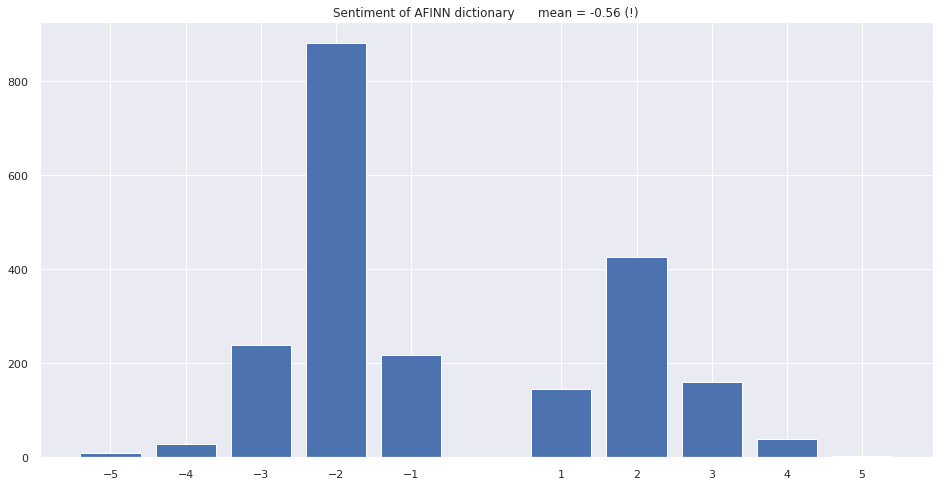

In [767]:
labels, counts = np.unique(afinn_dict['sentiment'], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title("Sentiment of AFINN dictionary      mean = %.2f (!)" %np.mean(np.array([*danishSentimentdict.values()])))
plt.show()

From the above histogram it is clear, that the dictionary has more negative words than positive. The mean sentiment is -0.56 and the median sentiment is -2 (!). This serves as a major caveat to the following analysis. If it is the case, that the negative words are generally equally likely to appear as the positve words, then sentiment scoring is biased in a negative direction by the dictionary. However, it could also be the case that the positive words just appear more frequently, in which the above does not pose a problem.

For comparative purposes, this does not pose a threat, assuming that the two media are equally exposed to the dictionary (omformulér?).

Note that there are no neutral words (sentiment = 0) in the dictionary, since these do not add to the final sentiment score. It does however make it difficult to assess the compatability between words in the dictionary and the articles - when a word doesn't recieve a score (and most of them turns out not to), is it because the word is inherently neutral or because the dictionary is deficient?

**Similarity assesment between dictionary and articles**

As previously stated, it is extremely important that there is a high similarity between the words in the dictionary and the words used by the media. Let's visualize a random subset of the articles and see which words counts in the scoring

In [411]:
# Draw random subset
n_articles = 10; random = None # Or None
 
polsmall = pol.sample(n=n_articles,  random_state=random) 
borssmall = bors.sample(n=n_articles,random_state=random)

def sentiment_colour(word):
    for dictword in danishSentimentdict.keys():
        if word == dictword: #       or: "  word.startswith(dictword):  " for Jonas' lemmatization
            if danishSentimentdict[dictword] < 0:
                return "\x1b[31m" + dictword + "\x1b[0m" + " "
            elif danishSentimentdict[dictword] > 0:
                return "\x1b[32m" + dictword + "\x1b[0m" + " "
    return word + ' '
        
# Stem headlines (politiken) - similarities
polsim = [[sentiment_colour(word) for word in headline.split(" ")] for headline in polsmall.clean_text]

# Stem headlines (børsen) - similarities
borssim = [[sentiment_colour(word) for word in headline.split(" ")] for headline in borssmall.clean_text]

# Politiken
print('*** POLITIKKEN *** ')
for i in range(n_articles):
    #print('\n \n', polsmall.Title.iloc[i])
    print('\n')
    [print(j, end="") for j in polsim[i]]


print('\n\n------------------------------------ \n')
print('*** Børsen *** ')
for i in range(n_articles):
    #print('\n \n', polsmall.Title.iloc[i])
    print('\n')
    [print(j, end="") for j in borssim[i]]

*** POLITIKKEN *** 


økonom direktør score million dongsalg 

toldfri sprutflaske beslaglægge 

popovic tilfreds 

suveræn dansker lave hattrick 

årig dømme hjemmerøveri årig binde hånd fod få gaffatape øje 

bendten kontroversiel scoring 

merkel hurtig socialdemokrat 

sigte lever våben parisangriber 

stikke ven ihjel kokkekniv slip straffe 

olieudslip føre fiskeriforbud 

------------------------------------ 

*** Børsen *** 


mulighed grøn energi usa 

mærskaktie fordoble marts – varsom 

ny bevis belaste stein bagge svenske makker 

overblik vigtigste nedslag pandora regnskab 

forbruger betaler prise sasopkøbe widerøe 

vestfrost støtte auke miljøkrav giver ny jobbe 

ambue udvide amerikansk kontrakt engangsendoskop 

faktum usa rentehop sætte retning 

blå boge anders eldrup 

sy rovsing koch elske broget verden 

The coloured words above illustrate the words with sentiment as identified by the sentiment dictionary - coloured accourding to their positive/negative contribution. The results are not too god, but not too bad either - the dictionary catches a lot of sentiment, but there's also a lot that it does not catch.

This is not a great result, but assuming that the two media are equally biased towards the dictionary, this does not pose a threat to the comparative study.

# Sentiment Analysis

## Børsen - sentiment scoring

Compute the sentiment for headlines using the overlap with the AFINN dictionary.

In [412]:
# Score all headlines
if run:
    bors.Sentiment = bors.clean_text.apply(lambda x: 
        sum([int(afinn_dict.sentiment.iloc[np.where(afinn_dict.word == Word)])
        for Word in x.split()
        if len(afinn_dict.sentiment.iloc[np.where(afinn_dict.word == Word)]) != 0]))

In [768]:
# Score themes
#    Computation benchmark: 4 min in Colab., 30 min in datalore
if run:
    bors_themes.Sentiment = bors_themes.clean_text.apply(lambda x: 
        sum([int(afinn_dict.sentiment.iloc[np.where(afinn_dict.word == Word)])
        for Word in x.split()
        if len(afinn_dict.sentiment.iloc[np.where(afinn_dict.word == Word)]) != 0]))

In [414]:
# Save sentiment scores
if run:
    with open('bors.data', 'wb') as filehandle:
        #store the data as binary data stream
        pickle.dump(bors, filehandle)
    with open('bors_themes.data', 'wb') as filehandle:
        #store the data as binary data stream
        pickle.dump(bors_themes, filehandle)

## Politiken - sentiment scoring

As before, the sentiment for politiken headlines are calculated.

In [769]:
# Calculate Sentiment on all Politiken headlines
if run:
    pol['Sentiment'] = 0
    pol.Sentiment = pol.clean_text.apply(lambda x: 
        sum([int(afinn_dict.sentiment.iloc[np.where(afinn_dict.word == Word)])
        for Word in x.split()
        if len(afinn_dict.sentiment.iloc[np.where(afinn_dict.word == Word)]) != 0]))

    Pcor['Sentiment'] = 0
    Pcor.Sentiment = Pcor.clean_text.apply(lambda x: 
        sum([int(afinn_dict.sentiment.iloc[np.where(afinn_dict.word == Word)])
        for Word in x.split()
        if len(afinn_dict.sentiment.iloc[np.where(afinn_dict.word == Word)]) != 0]))

    Pfin['Sentiment'] = 0
    Pfin.Sentiment = Pfin.clean_text.apply(lambda x: 
        sum([int(afinn_dict.sentiment.iloc[np.where(afinn_dict.word == Word)])
        for Word in x.split()
        if len(afinn_dict.sentiment.iloc[np.where(afinn_dict.word == Word)]) != 0]))

    Ppol['Sentiment'] = 0
    Ppol.Sentiment = Ppol.clean_text.apply(lambda x: 
        sum([int(afinn_dict.sentiment.iloc[np.where(afinn_dict.word == Word)])
        for Word in x.split()
        if len(afinn_dict.sentiment.iloc[np.where(afinn_dict.word == Word)]) != 0]))

## Convert sum of sentiment to average sentiment per word (for each headline)

Until now, the sentiment per headline is SUMMED over the words in the headline. One could argue that this is the proper measure of sentiment for a headline. We eventually found it more appropriate to consider the concentration of sentiment in a headline - i.e. to model the average sentiment per word (in a headline). Let's apply this averaging:

In [772]:
if run:
    # Calculate the mean sentiment for each headline
    # Note that mean_sent is changed to Sentiment in the loaded dataframe and Sentiment is changed to sum_sent.
    bors['mean_sent'] = bors.apply(lambda x: x.Sentiment/len(x.clean_text.split()) if x.Sentiment != 0 else 0, axis=1)
    bors_themes['mean_sent'] = bors_themes.apply(lambda x: x.Sentiment/len(x.clean_text.split()) if x.Sentiment != 0 else 0, axis=1)
    pol['mean_sent'] = pol.apply(lambda x: x.Sentiment/len(x.clean_text.split()) if x.Sentiment != 0 else 0, axis=1)
    Pfin['mean_sent'] = Pfin.apply(lambda x: x.Sentiment/len(x.clean_text.split()) if x.Sentiment != 0 else 0, axis=1)
    Ppol['mean_sent'] = Ppol.apply(lambda x: x.Sentiment/len(x.clean_text.split()) if x.Sentiment != 0 else 0, axis=1)
    Pcor['mean_sent'] = Pcor.apply(lambda x: x.Sentiment/len(x.clean_text.split()) if x.Sentiment != 0 else 0, axis=1)

Here's a snip of the top most positive and most negative articles of Politiken

In [786]:
# Top articles with highest sentiment of Politiken
pol[['Sentiment','Title','clean_text', 'DateTime']].sort_values(by='Sentiment',ascending=False).head()

,Sentiment,Title,clean_text,DateTime
668663,5.0,Hurra,hurra,2003-09-19
577756,4.0,Måske er miraklet der alligevel,mirakel,2007-01-20
678899,4.0,Et mesterværk,mesterværk,2003-02-12
650550,3.5,Superbt comeback,superb comeback,2004-06-18
634637,3.0,»Det er godt at være tilbage«,godt,2005-02-21


In [0]:
# Lowest sentiment of Politiken
bors[['Sentiment','Title','clean_text', 'Time']].sort_values(by='Sentiment',ascending=False).tail()

In [787]:
# Lowest sentiment of Politiken
bors[['Sentiment','Title','clean_text', 'Time']].sort_values(by='Sentiment',ascending=False).tail()

,Sentiment,Title,clean_text,Time
50709,-3.0,"""man kan ikke være et arrogant røvhul""",arrogant røvhul,2017-08-10
84163,-3.0,"""gør vi ikke noget bliver det værre""",værre,2013-09-04
84031,-3.0,"hvor dumme tror i, vi er?",dumme,2013-09-06
89465,-3.0,"""måske har jeg lidt storhedsvanvid""",storhedsvanvid,2013-02-13
65734,-4.0,"""det er katastrofalt""",katastrofal,2015-08-12


## Results

Having sentiment-scored all article headlines, we are finally ready to do some analysis. Let's have look at the overall sentiment for the two media



 Sentiment of Børsen:

 count    215676.000000
mean         -0.024609
std           0.301364
min          -4.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: Sentiment, dtype: float64


 Sentiment of Politiken:

 count    689175.000000
mean         -0.068284
std           0.344135
min          -4.000000
25%          -0.142857
50%           0.000000
75%           0.000000
max           5.000000
Name: Sentiment, dtype: float64


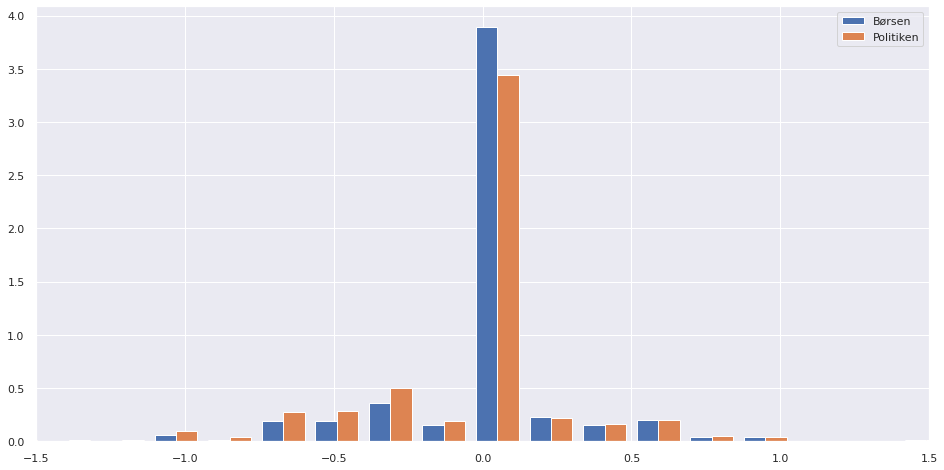

In [788]:
plt.hist([bors['Sentiment'], pol['Sentiment']],density=True, bins=50)
plt.xlim(-1.5,1.5)
plt.legend(['Børsen', 'Politiken'])

print('\n\n Sentiment of Børsen:\n\n',bors['Sentiment'].describe())
print('\n\n Sentiment of Politiken:\n\n', pol['Sentiment'].describe())

The overall sentiment of the two media are quite similar.

Børsen: µ = -0.025 (mean sentiment per word)

Politiken: µ = -0.068 (mean sentiment per word)

Is the difference in **mean sentiment** significant? Let's test it with a two-sample Welch t-test

In [795]:
ttest_ind(bors['Sentiment'], pol['Sentiment'], equal_var=False)

Ttest_indResult(statistic=56.71908870014094, pvalue=0.0)

A t-statistic = 58 corresponds to an *extremely* low p-value (much lower than the level of numeric stability of regular computers), i.e. an extremly significant difference in mean sentiment.

In conclusion: **Politiken is more negative-sentimented than Børsen.**

**Børsen has more neutral articles than Politiken**

In [796]:
print('Proportion of articles with sentiment = 0:')
print('Børsen %.2f' %np.mean(bors['Sentiment'] == 0))
print('Politiken %.2f' %np.mean(pol['Sentiment'] == 0))

Proportion of articles with sentiment = 0:
Børsen 0.70
Politiken 0.61


Note, that a score of sentiment = 0 can be interpreted either as a neutral article or as a result of an inadequate sentiment dictionary.

# Sentiment Analysis on themes: corona, finans, politik

Let's compare Børsen and Politiken on the following themes: *corona*, *finans*, *politik*. We will attempt to answer the question:

**Does Politiken and Børsen cover the themes with different sentiment?**

Theme: Corona		Politiken:  µ = -0.05				  Børsen: µ = -0.02
Theme: Finans		Politiken:  µ = -0.06				  Børsen: µ = 0.01
Theme: Politik		Politiken:  µ = -0.06				  Børsen: µ = -0.03
(Global mean		Politiken:  µ = -0.07				  Børsen: µ = -0.02)


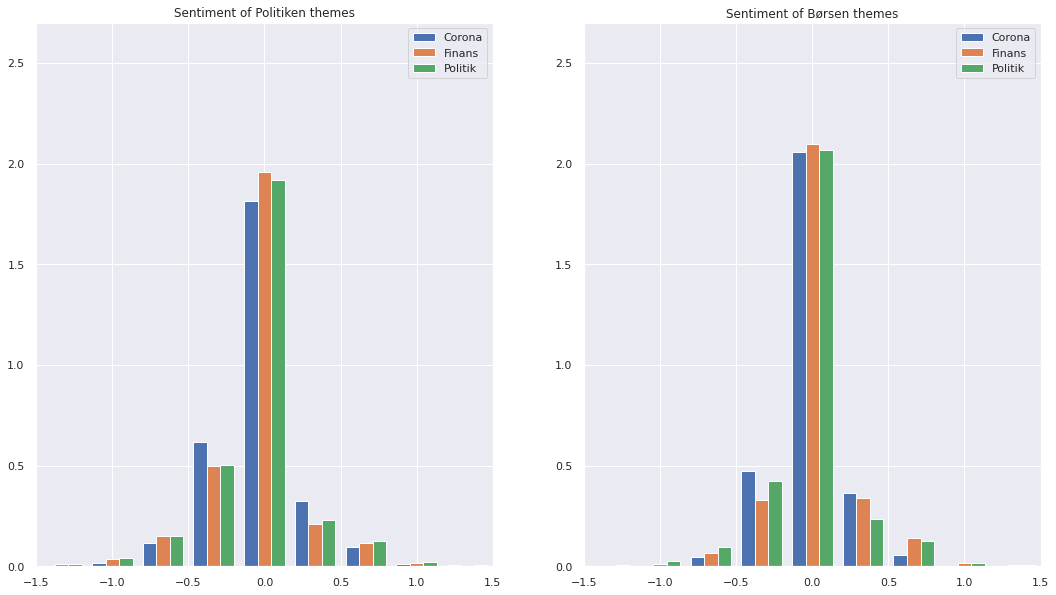

In [838]:
binss = np.linspace(-1.5, 1.5, num=10)

fig, (axs1, axs2) = plt.subplots(1,2)
fig.set_size_inches(18,10)

axs1.set_title('Sentiment of Politiken themes')
axs1.hist([Pcor['Sentiment'], Pfin['Sentiment'], Ppol['Sentiment']],density=True, bins=binss)
axs1.legend(['Corona', 'Finans', 'Politik'])
axs1.set_xlim(-1.5, 1.5)
axs1.set_ylim([0, 2.7])

axs2.set_title('Sentiment of Børsen themes')
axs2.hist([Bcor['Sentiment'], Bfin['Sentiment'], Bpol['Sentiment']],density=True, bins=binss)
axs2.legend(['Corona', 'Finans', 'Politik'])
axs2.set_xlim(-1.5, 1.5)
axs2.set_ylim([0, 2.7])
plt.show()

print('Theme: Corona\t\tPolitiken:  µ = %.2f\t\t\t\t  Børsen: µ = %.2f' %(Pcor['Sentiment'].mean(), Bcor['Sentiment'].mean()))
print('Theme: Finans\t\tPolitiken:  µ = %.2f\t\t\t\t  Børsen: µ = %.2f' %(Pfin['Sentiment'].mean(), Bfin['Sentiment'].mean()))
print('Theme: Politik\t\tPolitiken:  µ = %.2f\t\t\t\t  Børsen: µ = %.2f' %(Ppol['Sentiment'].mean(), Bpol['Sentiment'].mean()))
print('(Global mean\t\tPolitiken:  µ = %.2f\t\t\t\t  Børsen: µ = %.2f)' %(pol['Sentiment'].mean(), bors['Sentiment'].mean()))

From the above plots, it seems as if
1. *corona* is associated with a higher variance in sentiment, i.e. higher ups and downs in the news.
2. *finans* is associated with more positive sentiment in Børsen, while this doesn't seem to be the case for Politiken

**1. Is `corona` associated with a higher variance in sentiment?**

Let's test that with a *Levene* test of differecence in variance

In [836]:
print('--- Politiken ---')
print('Std. on corona: %.3f       Std. on finans: %.3f      Std. on politik: %.3f' %(np.std(Pcor.Sentiment), np.std(Pfin.Sentiment), np.std(Ppol.Sentiment)))
print(levene(Pcor.Sentiment, Pfin.Sentiment, Ppol.Sentiment))

print('\n\n--- Børsen ---')
print('Std. on corona: %.3f       Std. on finans: %.3f      Std. on politik %.3f' %(np.std(Bcor.Sentiment), np.std(Bfin.Sentiment), np.std(Bpol.Sentiment)))
levene(Bcor.Sentiment, Bfin.Sentiment, Bpol.Sentiment)

--- Politiken ---
Std. on corona: 0.275       Std. on finans: 0.303      Std. on politik: 0.326
LeveneResult(statistic=7.030603254656505, pvalue=0.0008846244353800878)


--- Børsen ---
Std. on corona: 0.208       Std. on finans: 0.256      Std. on politik 0.285


LeveneResult(statistic=50.987844491962946, pvalue=7.356312506438813e-23)

Well... There IS a signficant difference in variance of sentiment. But *corona* actually has the LOWEST variance.

**2. Is there a *significant* difference in sentiment of the two media on the themes?**

To asses whether there's a signficant difference on the mean sentiment on the themes of the two media, a *two-sample Welch t-test* is performed for each theme.
To account for the fact that Politiken is generally more negative sentimented than Børsen, the scores have been mean-centered before (by subtracting the global mean of the media), such that the test identifies theme-specific differences (and not just the global difference on sentiment).
Note, that the themes contribute to the overall mean and thus the method is slightly biased. However, the themes constitute only a small fraction of the articles, which is a neglectable impact.

In [837]:
print('Corona  t-test p-value: ', ttest_ind(Bcor.Sentiment - bors.Sentiment.mean(), Pcor.Sentiment - pol.Sentiment.mean(), equal_var=False)[1])
print('Finans  t-test p-value: ', ttest_ind(Bfin.Sentiment - bors.Sentiment.mean(), Pfin.Sentiment - pol.Sentiment.mean(), equal_var=False)[1])
print('Politik t-test p-value: ', ttest_ind(Bpol.Sentiment - bors.Sentiment.mean(), Ppol.Sentiment - pol.Sentiment.mean(), equal_var=False)[1])

Corona  t-test p-value:  0.01263715958884135
Finans  t-test p-value:  6.691380639793887e-10
Politik t-test p-value:  2.376370094443072e-13


I.e. the two media does present all themes with different sentiment - even when accounted for their general (mean) difference (!)

Let's end this section with a more comparative visualisation of the two media on each theme

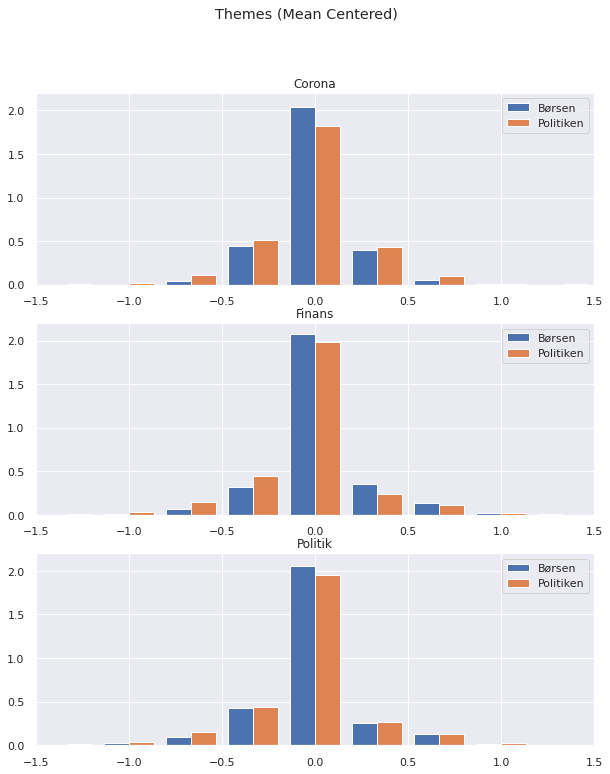

In [845]:
# Define plot parameters
ymax = 2.2
xlim = 1.5

fig, axs = plt.subplots(3)
fig.suptitle('Themes (Mean Centered)')
fig.set_size_inches(10, 12)

axs[0].hist([Bcor['Sentiment'] - bors.Sentiment.mean(), Pcor['Sentiment'] - pol.Sentiment.mean()],density=True, bins=binss)
axs[0].legend(["Børsen", "Politiken"])
axs[0].set_ylim([0, ymax])
axs[0].set_xlim([-xlim,xlim])
axs[0].set_title("Corona")

axs[1].hist([Bfin['Sentiment'] - bors.Sentiment.mean(), Pfin['Sentiment'] - pol.Sentiment.mean()],density=True, bins=binss)
axs[1].legend(["Børsen", "Politiken"])
axs[1].set_ylim([0,ymax])
axs[1].set_xlim([-xlim,xlim])
axs[1].set_title("Finans")


axs[2].hist([Bpol['Sentiment'] - bors.Sentiment.mean(), Ppol['Sentiment'] - pol.Sentiment.mean()],density=True, bins=binss)
axs[2].legend(["Børsen", "Politiken"])
axs[2].set_ylim([0,ymax])
axs[2].set_xlim([-xlim,xlim])
axs[2].set_title("Politik")
fig.show()

It's hard to identify any strong difference of sentiment on the different themes.

*Finans* is somewhat more positively presented in Børsen (as stated by the t-test)

*Politik* proved also to be signifcantly different (in mean) for the two media. Børsen is the more negative one.

# Analysis of headlines over time

## Length of headlines
Next, we conduct an explorative analysis of the two media headlines through time. Lets start by investigating the length of headlines through time for the two medias. 

As the sentiment from article to article varies greatly, a rolling mean of 1000 articles is used.


In [903]:
# Read stock market data and regering data.
# OMXC20 data has been acquired through Google Finance API
# Data on government has been acquired from Wikipedia.
omxc20 = pd.read_excel("omxc20.xlsx")
regering = pd.read_excel("regering.xlsx")

## Change bors and pol to datetime index
# disregard early period as articles are published very infrequently
polplot = pol[:-300]
borsplot = bors
pol["DateTime"] = pd.to_datetime(pol["DateTimeFormat"])

In [904]:
# Data Preprocessing
if run:
    ## Parse Date-strings to datetime format for Politiken
    dateTimePol = []
    # Translate to english
    pol.DateTime = pol.DateTime.str.replace("okt","oct")
    pol.DateTime = pol.DateTime.str.replace("maj","may")
    for i in range(0,len(pol)):

        dateTimePol.append(parse(pol.DateTime[i][:-10]))
        if i % 10000 == 0:
            print(i)
    # Add datetimes to dataframe
    pol["DateTimeFormat"] = dateTimePol

polplot = polplot.set_index(['DateTime'])
borsplot = borsplot.set_index(['Time'])
omxc20.Date = pd.to_datetime(omxc20["Date"])  

In [905]:
# Count length of headlines
polplot['Title_charlength'] = polplot['Title'].apply(len)
borsplot['Title_charlength'] = borsplot['Title'].apply(len)

polplot['ArticleRoll'] = polplot.Title_charlength.rolling(1000).mean()
borsplot = borsplot.sort_values(by='Time')
borsplot['ArticleRoll'] = borsplot.Title_charlength.rolling(1000).mean()

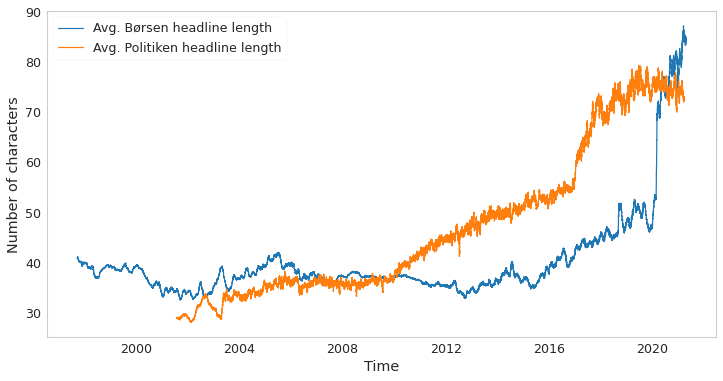

In [906]:
## Plot length of titles over time
jtplot.style()
bors = bors.sort_values(by='Time')
plt.rcParams["figure.figsize"] = (12,6)
fig = plt.figure()
ax = plt.axes()
ax.plot(borsplot.index, borsplot["ArticleRoll"], label='Average article headline length', color = "tab:blue")
ax.plot(polplot.index, polplot["ArticleRoll"], label='Average article headline length', color = "tab:orange")
plt.grid(False)
plt.ylabel("Number of characters")
plt.xlabel("Time")
ax.legend(["Avg. Børsen headline length","Avg. Politiken headline length"])
plt.show()
sns.set_theme()

As seen from the plot, the headline length for both of the medias has increased quite substantially. Whether this is due to increased revenue from longer click-baity articles or an attempt to condense relevant information into the headline itself is not further investigated, but could be possible explanations for this behaviour. It is especially interesting how Børsen quite suddenly has increased the lenght of their titles in 2019.

## Sentiment over time
Next it is investigated if external factors (Danish economy or the political orientation of the govenrment) exhibits any interesting relations with the sentiment scores over time for the different news media. 

For this purpose, data from the OMXC20 index is used, which is an index of the stocks of the 20 largest Danish companies on the stock market. The data contains the daily close-price since 3rd January 2000 through 26th april 2021. The data is rescaled to better fit the scale of the sentiment, and thus it is not directly meaningful to interpet the values of the OMXC20, but rather the behaviour through time and its relation to sentiment over time. As the economic index is subject to inflation and an overall growth of the Danish economy, the data is de-trended by subtracting the best fitting exponential function from the data.  

The average daily sentiment is used. As the variance in this is still quite high (for visualisation purposes) a 100 day rolling average is taken over this, to get an idea of the general sentiment in the given timeperiod.

Additionally, the political orientation (red/blue) of the current sitting government is added as the background color for the visualisation below.

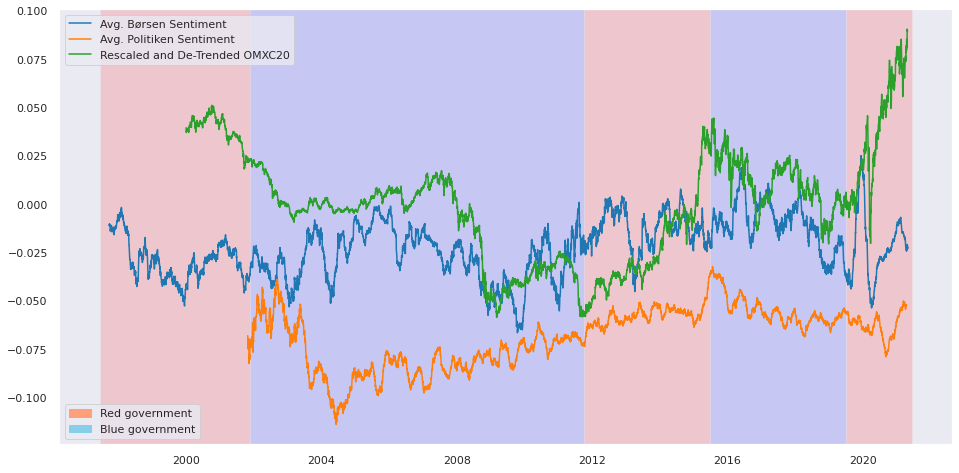

In [907]:
#%% AGGREGATED PLOTS
## Remake datasets as to avg. sentiment per day
bors1day = borsplot.resample('D').mean()
pol1day = polplot.resample('D').mean()

omxc20 = omxc20.resample('D', on = "Date").mean()
omxc20.DateTimeFormat = omxc20.index

# Interpolate missing values in omxc20
omxc20.Close = omxc20.Close.interpolate()

# Replace NAN-sentiment days with 0 (days with no published articles)
bors1day['Sentiment'] = bors1day['Sentiment'].fillna(0)
pol1day['Sentiment'] = pol1day['Sentiment'].fillna(0)

# Scale Down the "Close" variable to match sentiment values
omxc20["ScaledClose"] = omxc20["Close"] * 0.0002
# De-Trend OMXc25
omxc20["DetrendClose"] = scipy.signal.detrend(omxc20["Close"],type == "exponential")
omxc20["ScaledDetrendClose"] = omxc20["DetrendClose"] * 0.0002

# Average sentiment over N days (100)
bors1day['RollingSentiment'] = bors1day.Sentiment.rolling(100).mean()
pol1day['RollingSentiment'] = pol1day.Sentiment.rolling(100).mean()

# BØRSEN VS POLITIKEN VS OMXC20 SENTIMENT OVER TIME VS GOVERNMENT
plt.rcParams["figure.figsize"] = (16,8)
fig = plt.figure()
ax = plt.axes()
plt.grid(False)
ax.plot(bors1day.index, bors1day["RollingSentiment"], label='Average sentiment',color = "tab:blue")
ax.plot(pol1day.index, pol1day["RollingSentiment"], label='Average sentiment',color = "tab:orange")
ax.plot(omxc20.index, omxc20["ScaledDetrendClose"], label='Average sentiment',color="tab:green")
leg1 = ax.legend(["Avg. Børsen Sentiment", "Avg. Politiken Sentiment","Rescaled and De-Trended OMXC20"])
# Background color for government
# Find indexes where government changes
changedays = regering.Date[np.where(regering.Gov[:-1].values != regering.Gov[1:].values)[0]]
ax.axvspan(regering.Date[0], changedays.values[0], facecolor='red', alpha=0.15)
ax.axvspan(changedays.values[0], changedays.values[1], facecolor='blue', alpha=0.15)
ax.axvspan(changedays.values[1], changedays.values[2], facecolor='red', alpha=0.15)
ax.axvspan(changedays.values[2], changedays.values[3], facecolor='blue', alpha=0.15)
ax.axvspan(changedays.values[3], regering.Date[len(regering)-1], facecolor='red', alpha=0.15)


gov_r = mpatches.Patch(color='lightsalmon', label='Red government')
gov_b = mpatches.Patch(color='skyblue', label='Blue government')

leg2 = ax.legend(handles=[gov_r,gov_b],loc='lower left')
ax.add_artist(leg1)
plt.show()
sns.set_theme()

**Disclaimer**: One has to be extremely careful to make conclusions based solely on the data provided here, as the phenomenon of news article sentiment is very complex, and it becomes easy to find patterns and seek confimation bias accordingly. As such, we tread lightly not to suggest any causal connections, but merely some explorative insights into the data at hand.

There is a lot of information to dissect from the plot. By looking at the sentiment for Politiken and Børsen we see some interesting patterns. In general, the sentiment of Politiken is a bit more negative, compared to that of Børsen. The sentiments across the two medias vary greatly, and are quite different in behaviour. However, a shared trend for both medias sentiment is, that there is an overall increase in positive sentiment from timeperiod 2009 to 2016, in which afterwards the sentiment declines for both medias, moving low during the Corona pandemic but with a rather steep increase in the very last year. Whether this is in anyway related to e.g Donald Trump, who was often portrayed negatively in danish media is not further investigated, but it is however hinted at by this very sentence.

If we look closer at the period around the financial crisis of Denmark (ca. 2007-2009) it is seen that the sentiment of Børsen seems to fall in this period, together with the value of the OMXC20 index. Additionally with the rise of the economy following the crisis, it is again noticed that Børsen, a largely financial news outlet, seems to follow this which could suspect that the sentiment of Børsen articles are associated with the nations economic situation. There are however also periods which contradicts this statement, such as the divergence of the two around 2012, which indicates that the relationship if present, is not omnipresent. 

This same relationship is not as evident when judging the Politiken sentiment in the same time period, where it is seen that the sentiment seems to slowly rise somewhat consistently since the fairly sudden dip in 2004.

Comparing the sentiment through time with the political orientation of the sitting government doesn't seem to exhibit any clear structure, indicating that the medias are not extremely biased by this. Naturally the news coverage would (should) not be solely reliant on the orientation of the sitting government in a representative democracy, as it is probably influnced by a plethora of factors. However, one could argue that in times of Red government, the sentiment is growing (for both medias) and the oppsite in times of blue governments. As there haven't been many elections in the period, and the gradual changes in sentiment are not aligned with election this hypothesis is indeed hard to verify.

There is also a quite noticeable bump in the sentiment for Politiken around year 2016, overlapping the election. Whether this is influenced by this is hard to say, as it would require a further investigation of the topics (and their associated sentiment) in this particular period to investigate if Politiken is generally positive towards the change in leadership.

## Correlations

To further investigate the potential relation between the OMXC20 index and the sentiment for the two medias, correlations between these are investigated. For the binary variable, 1 means a red governement, 0 means a blue government.

In [911]:
regeringWithDateTimeIndex = regering
regeringWithDateTimeIndex["Date"] = pd.to_datetime(regeringWithDateTimeIndex["Date"])
regeringWithDateTimeIndex = regeringWithDateTimeIndex.set_index('Date')
regeringWithDateTimeIndex["Gov(int)"] = (regeringWithDateTimeIndex.Gov.values == "R") * 1

# CORRELATIONS
mergedDf = bors1day.merge(pol1day, left_index=True, right_index=True)
mergedDf = mergedDf.merge(omxc20, left_index=True, right_index=True)
mergedDf = mergedDf.merge(regeringWithDateTimeIndex, left_index=True, right_index=True)

omxc20corrdata = omxc20

mergedDf.rename(columns={'Sentiment_x':'Sentiment_bors'}, inplace=True)
mergedDf.rename(columns={'Sentiment_y':'Sentiment_pol'}, inplace=True)
mergedDf.rename(columns={'RollingSentiment_x':'RollingSentiment_bors'}, inplace=True)
mergedDf.rename(columns={'RollingSentiment_y':'RollingSentiment_pol'}, inplace=True)

start_date = '01-01-2001'
end_date = '15-04-2021'
mask = (mergedDf.index > start_date) & (mergedDf.index <= end_date)
data = mergedDf[mask]
dataforcorr = data[["RollingSentiment_bors","RollingSentiment_pol","ScaledDetrendClose","Gov(int)"]]
corrM = dataforcorr.corr()
# Present the correlation matrix
corrM.round(3)

,RollingSentiment_bors,RollingSentiment_pol,ScaledDetrendClose,Gov(int)
RollingSentiment_bors,1.000,0.268,0.239,0.177
RollingSentiment_pol,0.268,1.000,0.151,0.378
ScaledDetrendClose,0.239,0.151,1.000,0.037
Gov(int),0.177,0.378,0.037,1.000


The correlation values reflect what was seen in the visual inspecation, where the overall behavior of the curves did not seem to correlate greatly. Naturally, the average rolling sentiments are correlated with the daily sentiment, although not greatly. This indicates that the sentiment across a given day will naturally vary greatly as articles on different subjects by different authors are published. The correlation between the rolling sentiment for Børsen and Politiken does however indicate that there is a small relation between these, and that they both may be somewhat subject to an underlying shared sentiment trend. 

Interestingly the correlation between the government type and sentiment is quite high, with a higher sentiment for Politiken in times of a red government, compared to the sentiment of Børsen. This may further indicate the general presumption that Politiken is predominantly a left-wing media, with Børsen being a right-wing media.

As the correlation measures the co-variance for the series across the entire period, it might mask some shortlived temporal trends. Let's investigate the correlation between the series in the years 2007-2013.

In [918]:
start_date = '01-01-2008'
end_date = '01-01-2011'
mask = (dataforcorr.index > parse(start_date)) & (dataforcorr.index <= parse(end_date))
datazoom = dataforcorr[mask]
corrMzoom = datazoom.corr()
corrMzoom.round(3)

,RollingSentiment_bors,RollingSentiment_pol,ScaledDetrendClose,Gov(int)
RollingSentiment_bors,1.000,0.010,0.538,NaN
RollingSentiment_pol,0.010,1.000,-0.347,NaN
ScaledDetrendClose,0.538,-0.347,1.000,NaN
Gov(int),NaN,NaN,NaN,NaN


Looking at the correlation matrix here we see a quite drastic change in the relation between the series. It is seen that the correlation between the OMXC20 index and rolling sentiments are much greater. Further, the correlation between the OMXC20 index and Politiken is negative, while the correlation between OMXC20 and Børsen is positive. As this period is during the danish financial crisis it may indicate that Børsen, a largely financial newsmedia, are presenting news more negatively, while Politiken presents news more positively. 

(The correlations with Gov is NaN since there is only 1 unique value in this subset period)

# Word Clouds

To get insight into the content of the two media, wordclouds are created for each of them and shown below. It is noticable that the most frequent words in both media are *dansk*, *Danmark* and *USA*. Remember, however, that the words are lemmatized, so for instance anything mentioning USA or referring to USA's something is lemmatized to USA.

In [840]:
def show_wordcloud(df, title):
    text = ' '.join(df['clean_text'].dropna().astype(str).tolist())
    fig_wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

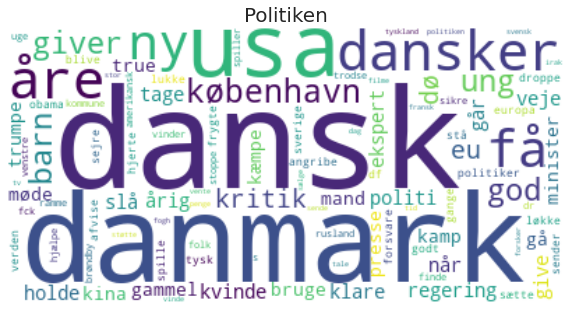

In [841]:
show_wordcloud(pol, "Politiken")

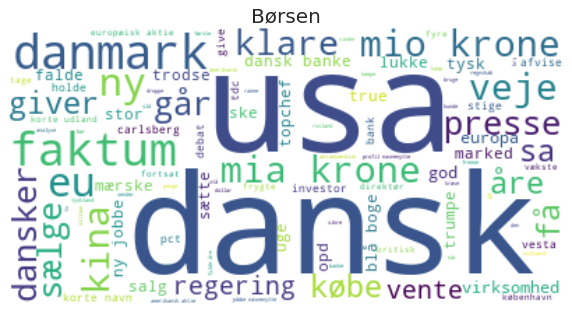

In [842]:
show_wordcloud(bors, "Børsen")

**Below you have the opportunity to find the highlights of a period of your choosing**. Simply enter a start and an end date of your search. You could try to find the week of 9/11 or the days after Donald Trump won the presidential election. Default state is Politiken in the days surrounding the devastating tsunami of 2004, where words such as *flodbølge/Tsunami*, *Thailand*, *dræbe/kill* and *nødhjælp/emergency aid* are dominating.

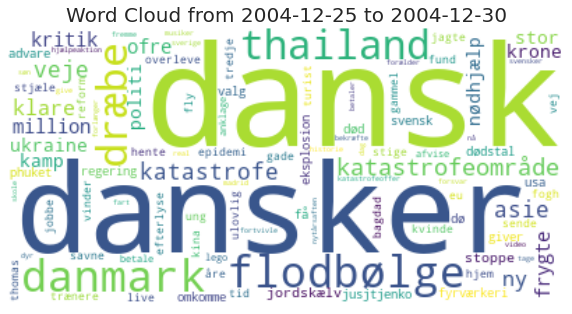

In [926]:
media = pol #Select between [pol, bors, Pcor, Pfin, Ppol, Bcor, Bfin, Bpol]
begin = '2004-12-25'
end = '2004-12-30'
show_wordcloud(pol[(media.DateTime >= parse(begin)) & (media.DateTime <= parse(end))], 'Word Cloud from ' + begin + ' to ' + end)

From the wordclouds it is somewhat clear that the two media have different foci in the topics they cover. For instance, Børsen seems to cover more topics from an economic point of view, often mentioning *mio* and *mia*, *buy* and *sell* while Politiken might take a more populist angle. To further investigate this claim, latent topics are modelled in the next section.

# Topic modelling

Now let's dive deeper into the content of the two media. In this section latent topics are identified for Børsen and Politiken using Latent Dirichlet Allocation. The sentiment for the different found topics are evaluated to investigate if the medias are more or less positive towards that given topic - for topics that are latent for both media. Initially let's see how many words are present in the data

In [927]:
random.seed(9001)
polldadata = pol[pol['clean_text'].notna()]

polldadata["DateTime"] = pd.to_datetime(polldadata["DateTimeFormat"]) # DELETE THIS LINE LATER AS IT IS DONE PREVIOUSLY

words_all_bors = Counter(" ".join(bors.Title).split(" ")).items()
words_clean_bors = Counter(" ".join(bors.clean_text).split(" ")).items()

words_all_pol = Counter(" ".join(polldadata.Title).split(" ")).items()
words_clean_pol = Counter(" ".join(polldadata.clean_text).split(" ")).items()

# Number of unique words
print('Number of unique words before cleaning Børsen: ', len(words_all_bors))
print('Number of unique words after cleaning Børsen: ',len(words_clean_bors))

print('Number of unique words before cleaning Politiken: ', len(words_all_pol))
print('Number of unique words after cleaning Politiken: ',len(words_clean_pol))

Number of unique words before cleaning Børsen:  128555
Number of unique words after cleaning Børsen:  82786
Number of unique words before cleaning Politiken:  390937
Number of unique words after cleaning Politiken:  188900


Next, we perform the Latent Dirichlet Allocation. This is done by using the sklearn decomposition package. The words are represented as a Bag-of-Word (BoW) and the fit is performed on a select subset of data. In this case the topics for 2020 and 2021 are investigated. If you wish to explore another date range, simply change the startdate and enddate variables.

In [654]:
vectorizer=CountVectorizer()
startdate = "01-01-2020"
enddate = "16-05-2021"

bors_lda = bors[(bors.Time > startdate) & (bors.Time < enddate)]
descriptions_bow_bors = vectorizer.fit_transform(bors_lda["clean_text"])   #creates a BoW representation
description_vocabulary_bors = vectorizer.get_feature_names()  #gets the words that correspond to each element of the BoW

pol_lda = polldadata[(polldadata.DateTime > startdate) & (polldadata.DateTime < enddate)]
descriptions_bow_pol=vectorizer.fit_transform(pol_lda["clean_text"])   #creates a BoW representation
description_vocabulary_pol = vectorizer.get_feature_names()  #gets the words that correspond to each element of the BoW

The LDA models are now fitted

In [655]:
# Train on Børsen #long-ish runtime
lda_bors=LatentDirichletAllocation(n_components=10, learning_method='batch')
x_bors=lda_bors.fit_transform(descriptions_bow_bors)

In [656]:
# Train Politiken #long-ish runtime
lda_pol=LatentDirichletAllocation(n_components=10, learning_method='batch')
x_pol=lda_pol.fit_transform(descriptions_bow_pol)

In [657]:
# Function to print important/frequent/popular words :)
def print_top_words(model, feature_names, n_top_words, sent):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % int(topic_idx+1)
        message += "\t Sentiment:  "+ str(np.round(sent[topic_idx], 5))+"\t"
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [658]:
topics = ['LDA_topic1','LDA_topic2','LDA_topic3','LDA_topic4','LDA_topic5','LDA_topic6','LDA_topic7','LDA_topic8','LDA_topic9','LDA_topic10']
topicdf_bors = pd.DataFrame(data=x_bors[:,:],index=bors_lda.index,columns=topics)

topicdf_pol = pd.DataFrame(data=x_pol[:,:],index=pol_lda.index,columns=topics)

bors_lda = bors_lda.merge(topicdf_bors, left_index=True, right_index=True)
pol_lda = pol_lda.merge(topicdf_pol, left_index=True, right_index=True)

Now it could be interesting to look into the sentiment of each topic. There are multiple ways to do this. To take into account the occurance of the words, we will take a headline-based approach, where each headline is soft-assigned a proportion to each topic, and then the topic sentiment is simply a weighted average of it's headlines.

The proportion of the sentiment in each topic for all titles is calculated. I.e. the sentiment of a headline are multiplied with the proprotion of the topic in a given headline.

In [659]:
# Calculate the proportion of sentiment in each topic for all titles
dfbors = bors_lda.apply(lambda x: x.Sentiment * x.iloc[len(bors.columns):], axis=1)
dfbors.columns = [s + "_sent" for s in dfbors.columns]
bors_lda = bors_lda.merge(dfbors, left_index=True, right_index=True)

# Calculate the proportion of sentiment in each topic for all titles
dfpol = pol_lda.apply(lambda x: x.Sentiment * x.iloc[len(pol.columns):], axis=1)
dfpol.columns = [s + "_sent" for s in dfpol.columns]
pol_lda = pol_lda.merge(dfpol, left_index=True, right_index=True)

And finally, results are printed!

In [660]:
sentLDAcols = ['LDA_topic1_sent', 'LDA_topic2_sent', 'LDA_topic3_sent',
       'LDA_topic4_sent', 'LDA_topic5_sent', 'LDA_topic6_sent',
       'LDA_topic7_sent', 'LDA_topic8_sent', 'LDA_topic9_sent',
       'LDA_topic10_sent']

print("Børsen: ")  

print_top_words(lda_bors, description_vocabulary_bors, 10, bors_lda[sentLDAcols].mean(axis=0))
print("Politiken:")
print_top_words(lda_pol, description_vocabulary_pol, 10, pol_lda[sentLDAcols].mean(axis=0))

Børsen: 
Topic #1: 	 Sentiment:  -0.0027	banke dansk rente åre jysk milliard mio sætte kommentar lund
Topic #2: 	 Sentiment:  0.00256	aktie usa marked aktiestatus europa fokus pct aktielukke åbner stige
Topic #3: 	 Sentiment:  -0.00303	bocian helle økonomisk ib økonomi regering børs danmark stor coronakrise
Topic #4: 	 Sentiment:  -0.00115	dansk bank bid falde amerikansk usa pct banke åre virksomhed
Topic #5: 	 Sentiment:  -0.00497	første kvartal corona usa forventning dansk pct den ny vente
Topic #6: 	 Sentiment:  -0.00244	krone mia mio dansker rejse regering ny åre købe vie
Topic #7: 	 Sentiment:  -0.00047	debat virksomhed den dansk åre god danmark corona direktør vie
Topic #8: 	 Sentiment:  -0.00222	ske trumpe genåbning første mette usa klare vaccine frederiksen gange
Topic #9: 	 Sentiment:  -0.00088	dollar pro novo nordisk eu amerikansk johnson valuta jeg mia
Topic #10: 	 Sentiment:  -0.00524	coronavirus smitte ny usa danmark kina million død antal teste

Politiken:
Topic #1: 	 Sen

Lets dive into some of the topics identified. The 1st Topic for Børsen seems to be associated with finance and banking, whereas fx Topic 10 for Børsen appears to be related to coronavirus, with important words such China, death, testing etc.

Looking at the 1st Topic for Politiken it seems to be related to politics, especially Trump and Joe Biden, with addition of Støjberg, a Danish politician who were subject to a lot of media exposure in the period.
Looking at the 1st Topic for Politiken it seems to be related to politics, especially Trump and Joe Biden, with addition of Støjberg, a Danish politician who were subject to a lot of media exposure in the period.

Judging the sentiment of Børsen, it is seen that Topic #2 is the topic with most positive sentiment, and that the topic is heavily related to words associated with stocks, europe and USA. The most negative Topic for børsen is Topic #10, which as mentioned is related to the coronavirus. This would indicate that Børsen is inclined to persent news related to the stockmarket as positive, while news related to coronavirus as negative. This is quite in line with the pandemic shutting down the world and costing many peoples lives, while in the same period the stockmarket has had a huge upswing reaching all time highs.

Looking at the Topic with highest sentiment score for politiken (Topic #8) it is seen that the topic is associated with denmark and culture, with Bente Klarlund and Søren Ryge, likely also Søren Brostrøm as these have had a lot of similar exposure in the period. The lowest sentiment topic (Topic #9) is also related to cornavirus, with words such as infection, death and corona. It is quite natural that this topic is presented in a negative light, as the pandemic has had huge negative consequences on peoples lives.

Overall, the topics presented by Børsen are more closely related to finance, and those of Politiken are associated with happenings in Denmark.

# Conclusion

THE END! Thanks for embarking on this journey with us. We hope you have had a positively sentimented experience.

Before you go onwards with your life, we would like to conclude and summarize our findings.

Firstly, we saw that Politiken and Børsen have different sentiment in their news, even though they should generally present the world objectively. It wasn't much, but it was extremely statistically significant (due to the large amount of data).

Secondly, we saw that Børsen and Politiken presented all themes with significantly different sentiment. `Finance` was presented positively in Børsen, while this wasn't the case for Politiken. Suprinsingly, `corona` had the lowest variance in sentiment among the thems.

Thirdly, we saw that sentiment has not changed overall over time. The news has not become more negative (korrekt?). What has happened, however, is that the length of articles has increased a lot in the last years. The change of sentiment over time did not reflect the samme pattern in the Danish stock market - although for some periods of time there seemed to occur temporal trends, but whether these are due to chance or are related is hard to say.

From the topic modelling we identified latent topics related to Danish culture, politics, coronavirus and finance from the headlines. Here it was seen that Børsens latent topics seemed to revolve more around finance, and that both Politiken and Børsen had negative sentiment in the topic related to coronavirus.

# Further Analysis

This study has put many doors ajar, that we decided not to open further. The most obvious point for further analysis, had it been possible, was to acquire the full text of the articles. This would enable more extensive research into the true sentiments of the articles and hence topics, as more words would contribute to the scoring.

It could be cool to further analyze the sentiment of coverage by Børsen and Politiken of topics found using LDA.
By extension, dynamic topic modelling is an option to assess the development of topics over time for both media. 

More insight into the articles with the strongest sentiment would be interesting to assess the effectiveness of the Afinn dictionary.

We also considered translating the headlines to English to enable the use of more sophisticated sentiment dictionaries that work on embeddings instead of BoW, but APIs to translate text had too strict limits to make this feasible. Additionally, the translation from danish to english might alter the sentiment inherently as the translated headline might have a different sentiment, despite having the same meaning.

The clean_text function could also include a named entity identifier to be better at finding names of relevant politicians as well as places. Asien (Asia in English) is lemmatized to *asie* which is *gherkin* in English, and *Trump* is lemmatized to *trumpe*.
